In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import zipfile
import numpy as np
tf.random.set_seed(42)
np.random.seed(42)

# Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.


In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-01-05 16:07:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M   160MB/s    in 1.0s    

2022-01-05 16:08:00 (160 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [3]:
BATCH_SIZE = 32

In [4]:
train = tf.keras.utils.image_dataset_from_directory('/content/10_food_classes_10_percent/train',
                                                    label_mode='categorical',
                                                    image_size=(224,224),
                                                    batch_size=BATCH_SIZE
                                                    )
test = tf.keras.utils.image_dataset_from_directory('/content/10_food_classes_10_percent/test',
                                                   label_mode='categorical',
                                                   image_size=(224,224),
                                                   batch_size=BATCH_SIZE
                                                    )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
classes = train.class_names

In [6]:
for i in train.take(1):
  shape = i[1].numpy().shape
  break

In [7]:
N_CLASSES = shape[1]
N_CLASSES

10

In [8]:
train

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
# for i in train.take(1):
#   print(i[0], i[1])
#   break

In [10]:
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, pooling='max')

inputs = tf.keras.layers.Input(shape=(224,224,3))
x = base_model(inputs)
outputs = tf.keras.layers.Dense(N_CLASSES)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [11]:
24*32

768

In [12]:
train_steps = sum(1 for _ in train)
test_steps = sum(1 for _ in test)

In [13]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False, 
                                                         save_freq='epoch',
                                                         verbose=0)

In [14]:
train = train.cache().repeat().shuffle(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test = test.cache().repeat().shuffle(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [16]:
model.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #, label_smoothing=.1), 
              metrics='accuracy')

model.fit(train, validation_data=test, steps_per_epoch=train_steps, validation_steps=int(.25*test_steps), epochs=10,)# callbacks=[checkpoint_callback])

Epoch 1/10
24/24 [==============================] - 30s 828ms/step - loss: 8.7761 - accuracy: 0.0987 - val_loss: 6.4425 - val_accuracy: 0.1217
Epoch 2/10
24/24 [==============================] - 17s 731ms/step - loss: 8.5825 - accuracy: 0.1080 - val_loss: 8.2545 - val_accuracy: 0.1513
Epoch 3/10
24/24 [==============================] - 18s 738ms/step - loss: 9.3843 - accuracy: 0.1263 - val_loss: 8.6690 - val_accuracy: 0.1349
Epoch 4/10
24/24 [==============================] - 17s 713ms/step - loss: 9.8216 - accuracy: 0.1325 - val_loss: 9.3058 - val_accuracy: 0.1266
Epoch 5/10
24/24 [==============================] - 17s 726ms/step - loss: 8.9837 - accuracy: 0.1227 - val_loss: 8.8454 - val_accuracy: 0.1266
Epoch 6/10
24/24 [==============================] - 17s 724ms/step - loss: 8.2313 - accuracy: 0.1200 - val_loss: 8.2726 - val_accuracy: 0.1217
Epoch 7/10
24/24 [==============================] - 17s 736ms/step - loss: 8.0591 - accuracy: 0.1198 - val_loss: 8.2512 - val_accuracy: 0.1151

### Efficient Nets "have" a rescale layer, but when you see accuracy off and dwindling, best to try rescaling manually

In [18]:
for layer in base_model.layers[:5]:
  print(layer)

In [19]:
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, pooling='max')

inputs = tf.keras.layers.Input(shape=(224,224,3))
x = tf.keras.layers.Rescaling(1/255.)(inputs)
x = base_model(x)
outputs = tf.keras.layers.Dense(N_CLASSES)(x)

scaled = tf.keras.Model(inputs=inputs, outputs=outputs)

scaled.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=.1), metrics='accuracy')

scaled.fit(train, validation_data=test, steps_per_epoch=train_steps, validation_steps=int(.25*test_steps), epochs=10, )#callbacks=[checkpoint_callback])

Epoch 1/10
24/24 [==============================] - 30s 839ms/step - loss: 5.3089 - accuracy: 0.1211 - val_loss: 3.4649 - val_accuracy: 0.0954
Epoch 2/10
24/24 [==============================] - 18s 749ms/step - loss: 3.5071 - accuracy: 0.1068 - val_loss: 3.6218 - val_accuracy: 0.1118
Epoch 3/10
24/24 [==============================] - 17s 725ms/step - loss: 3.3344 - accuracy: 0.1052 - val_loss: 3.4248 - val_accuracy: 0.1036
Epoch 4/10
24/24 [==============================] - 17s 723ms/step - loss: 5.6890 - accuracy: 0.0915 - val_loss: 4.9809 - val_accuracy: 0.1135
Epoch 5/10
24/24 [==============================] - 18s 746ms/step - loss: 3.6451 - accuracy: 0.1081 - val_loss: 4.7582 - val_accuracy: 0.1086
Epoch 6/10
24/24 [==============================] - 17s 725ms/step - loss: 3.3582 - accuracy: 0.1230 - val_loss: 4.9169 - val_accuracy: 0.1151
Epoch 7/10
24/24 [==============================] - 17s 734ms/step - loss: 3.3768 - accuracy: 0.1667 - val_loss: 5.5165 - val_accuracy: 0.1168

### Okay, that didn't work. Back to model 1

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=.1), 
              metrics='accuracy')

model.fit(train, validation_data=test, steps_per_epoch=train_steps, validation_steps=int(.25*test_steps), epochs=10, callbacks=[checkpoint_callback])

Epoch 1/10
24/24 [==============================] - 31s 856ms/step - loss: 8.4013 - accuracy: 0.1185 - val_loss: 8.1545 - val_accuracy: 0.1365
Epoch 2/10
24/24 [==============================] - 18s 770ms/step - loss: 7.9269 - accuracy: 0.1393 - val_loss: 7.6058 - val_accuracy: 0.1168
Epoch 3/10
24/24 [==============================] - 18s 742ms/step - loss: 7.5044 - accuracy: 0.1134 - val_loss: 7.7012 - val_accuracy: 0.1069
Epoch 4/10
24/24 [==============================] - 18s 751ms/step - loss: 7.9237 - accuracy: 0.1213 - val_loss: 8.0113 - val_accuracy: 0.1266
Epoch 5/10
24/24 [==============================] - 18s 747ms/step - loss: 8.3492 - accuracy: 0.1080 - val_loss: 8.3215 - val_accuracy: 0.1069
Epoch 6/10
24/24 [==============================] - 18s 763ms/step - loss: 7.9043 - accuracy: 0.1093 - val_loss: 8.4408 - val_accuracy: 0.1118
Epoch 7/10
24/24 [==============================] - 18s 754ms/step - loss: 8.0204 - accuracy: 0.1107 - val_loss: 8.1306 - val_accuracy: 0.1086

# Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [20]:
# classes = ['chicken_curry',
#  'chicken_wings',
#  'fried_rice',
#  'grilled_salmon',
#  'hamburger',
#  'ice_cream',
#  'pizza',
#  'ramen',
#  'steak',
#  'sushi'] #train.class_names

In [21]:
def display_one(image, clas, pred, subplot):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  color = 'green' if clas==pred else 'red'
  plt.title(f'{clas} \n {pred}', color=color, ha='center', weight='bold')

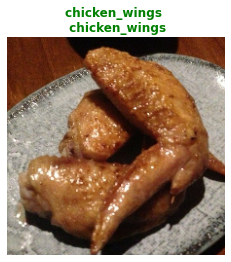

In [22]:
batch = train.take(1)
for i in batch.take(1):
  image = i[0][0]
  classIdx = tf.argmax(i[1][0],)# axis=1)
  clas = classes[classIdx]

  display_one(image/255., clas, clas, 111)

In [23]:
def batch_nine(dataset):
  for i in dataset.take(1):
    images = i[0][:9]
    labels = tf.argmax(i[1][:9], axis=1)
    return images, labels
    

In [41]:
def viz_predict(dataset, model=None, classes=None):

  dataset=dataset.shuffle(BATCH_SIZE*3)

  if classes is None:
    try:
      classes = dataset.class_names
    except:
      print('Try a list of classes')
  
  imgs, labs = batch_nine(dataset)
  imgs = imgs / 255.
  clas = [classes[idx] for idx in labs]
  
  if model is not None:
    preds = model.predict(imgs)
    predIdx = tf.argmax(tf.nn.softmax(preds), axis=1)
    pred = [classes[idx] for idx in predIdx]
  else:
    pred=clas

  plt.figure(figsize=(13,13))
  for i in range(9):
    display_one(imgs[i], clas[i], pred[i], 331+i)
  plt.tight_layout()
  plt.subplots_adjust(wspace=.1, hspace=.15)
  plt.show()

  return preds



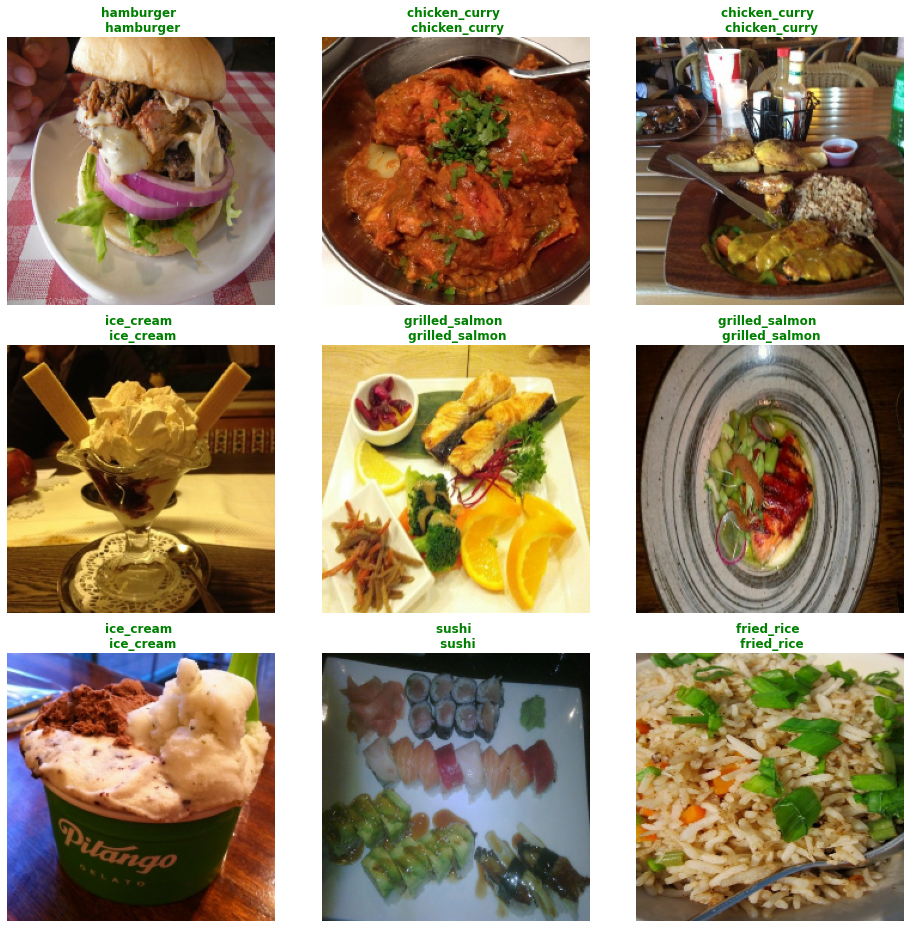

In [27]:
viz_predict(train, classes=classes)

# Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?


In [29]:
for layer in base_model.layers[-20:]:
  layer.trainable = True

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(.0001), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=.1),
              metrics='accuracy')

model.fit(train, validation_data=test, steps_per_epoch=train_steps, 
          validation_steps=int(.25*test_steps), epochs=20, callbacks=[checkpoint_callback], 
          initial_epoch=10)

Epoch 11/20
24/24 [==============================] - 31s 854ms/step - loss: 58.9562 - accuracy: 0.1341 - val_loss: 38.9236 - val_accuracy: 0.1645
Epoch 12/20
24/24 [==============================] - 18s 767ms/step - loss: 33.9135 - accuracy: 0.1653 - val_loss: 29.3983 - val_accuracy: 0.1645
Epoch 13/20
24/24 [==============================] - 18s 780ms/step - loss: 18.1336 - accuracy: 0.1849 - val_loss: 22.9585 - val_accuracy: 0.1332
Epoch 14/20
24/24 [==============================] - 18s 750ms/step - loss: 10.1364 - accuracy: 0.1967 - val_loss: 14.9415 - val_accuracy: 0.1990
Epoch 15/20
24/24 [==============================] - 18s 750ms/step - loss: 5.1081 - accuracy: 0.2633 - val_loss: 11.4285 - val_accuracy: 0.1826
Epoch 16/20
24/24 [==============================] - 18s 778ms/step - loss: 3.8139 - accuracy: 0.2943 - val_loss: 6.9947 - val_accuracy: 0.2336
Epoch 17/20
24/24 [==============================] - 18s 776ms/step - loss: 2.6694 - accuracy: 0.3346 - val_loss: 5.2592 - val_

# Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?


In [35]:
for layer in base_model.layers[-30:]:
  layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(.0001), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=.1),
              metrics='accuracy')

model.fit(train, validation_data=test, steps_per_epoch=train_steps, 
          validation_steps=int(.25*test_steps), epochs=30, callbacks=[checkpoint_callback], 
          initial_epoch=20)

Epoch 21/30
24/24 [==============================] - 31s 853ms/step - loss: 1.8631 - accuracy: 0.5120 - val_loss: 2.4473 - val_accuracy: 0.3503
Epoch 22/30
24/24 [==============================] - 18s 774ms/step - loss: 1.5437 - accuracy: 0.6160 - val_loss: 2.2219 - val_accuracy: 0.3750
Epoch 23/30
24/24 [==============================] - 18s 771ms/step - loss: 1.3415 - accuracy: 0.6953 - val_loss: 2.0415 - val_accuracy: 0.4128
Epoch 24/30
24/24 [==============================] - 18s 773ms/step - loss: 1.1831 - accuracy: 0.7695 - val_loss: 1.9941 - val_accuracy: 0.4013
Epoch 25/30
24/24 [==============================] - 18s 761ms/step - loss: 1.0706 - accuracy: 0.8227 - val_loss: 1.9368 - val_accuracy: 0.4276
Epoch 26/30
24/24 [==============================] - 18s 745ms/step - loss: 0.9390 - accuracy: 0.8757 - val_loss: 1.8425 - val_accuracy: 0.4704
Epoch 27/30
24/24 [==============================] - 17s 735ms/step - loss: 0.8942 - accuracy: 0.9132 - val_loss: 1.8421 - val_accuracy:

## The high accuracy in the training set shows that the patterns in training are being learned very well. If val_accuracy slows in improvement here, we would be overfitting. We can assume the model isn't generalizing extremely well.

Can see we're totally overtrained here -- every prediction is ice cream

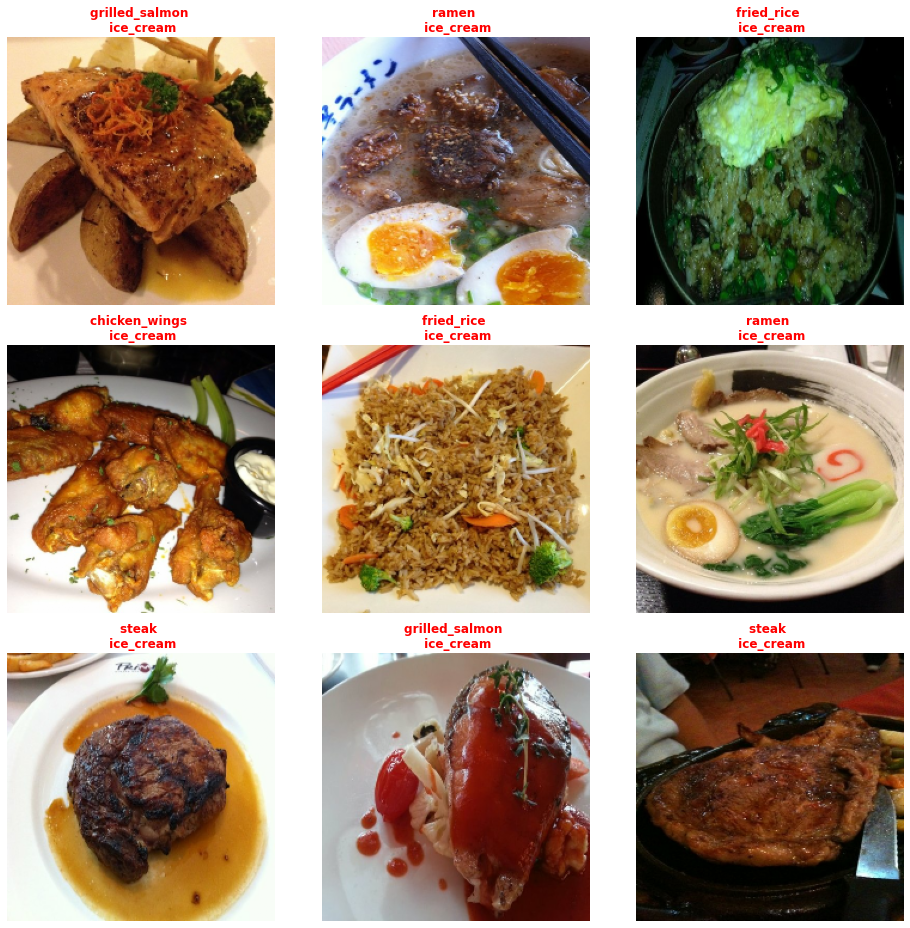

In [49]:
preds = viz_predict(test, model=model, classes=classes)

In [47]:
tf.nn.softmax(preds)

<tf.Tensor: shape=(9, 10), dtype=float32, numpy=
array([[0.00903534, 0.00520899, 0.02902276, 0.00250834, 0.02584484,
        0.8930155 , 0.00790467, 0.00470229, 0.00513582, 0.01762155],
       [0.00885705, 0.00524224, 0.02794905, 0.00242175, 0.02521335,
        0.89580667, 0.00744262, 0.00453255, 0.00505312, 0.01748148],
       [0.00915566, 0.00532382, 0.02851217, 0.00249044, 0.0257526 ,
        0.893963  , 0.00760557, 0.00470501, 0.00515878, 0.01733284],
       [0.00895263, 0.00511648, 0.0285923 , 0.00253799, 0.02587572,
        0.8929618 , 0.00792559, 0.00463215, 0.00519746, 0.01820792],
       [0.00916047, 0.0054507 , 0.02848604, 0.00244318, 0.02574405,
        0.8948933 , 0.00723873, 0.00461938, 0.00500738, 0.01695686],
       [0.00906747, 0.00519814, 0.02820503, 0.00248706, 0.02546409,
        0.89505684, 0.00751195, 0.00454623, 0.00509145, 0.01737183],
       [0.00883915, 0.00513294, 0.02798874, 0.00243946, 0.02530578,
        0.89511186, 0.00780469, 0.00459828, 0.00506346, 0.017